In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import GPy
import geopandas
import geoplot
import random
import os
import shutil
import time
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from utils import *
from runmanager import *
from experiment import *
from plot_utils import plot_timeseries, print_summary_of_results

from shapely.geometry import box, mapping
import cartopy.crs as ccrs

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

### Import data

In [4]:
# Import dataframe
path = '..\..\PhD/data/pickle/df_stations_all_nonzero.pkl'
st = pd.read_pickle(path)

# Replace NaN values from observed precipitation columns in observations Dataframe so that observed precipitation column can be read as float 

st['Prec'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
st['Prec'].replace(r'.', np.nan, regex=True, inplace=True)
st.dropna(inplace=True)

start="1998-01-01"
end="2007-12-31"

st = st[st['Date'].between(start,end)]

In [251]:
st['BC_diff'] = st['model_precipitation'] - st['wrf_bcp']
aux = st.groupby('Station').sum()
aux.reset_index(inplace=True)
bc_stations = aux['Station'][aux['BC_diff']!=0].unique()

### K-fold train/validation split

In [6]:
flag=1
if flag:
    st_names = bc_stations
else:
    st_names = st['Station'].unique()

In [7]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.2)

st_names_dict = {}
st_names_dict['train'] = list(st_names[:split*3])
st_names_dict['val'] = list(st_names[split*3:split*4])
st_names_dict['test'] = list(st_names[split*4:])

#st_names_train = list(st_names[:split*4])
#st_names_val = list(st_names[split*4:])
#st_names_test = list(set(list(st['Station'].unique())) - set(list(st_names)))

print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

18 stations used for training, 6 used for validation, and 8 used testing


In [8]:
split_dict = {}

kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(st_names)

for i, (train_index, val_index) in enumerate(kf.split(st_names)):
    split_dict[f'k{i}'] = {f'train': st_names[train_index],
                           f'val' : st_names[val_index]
                          }

### Prepare data

In [9]:
data = {}

predictors = ['model_precipitation',
              'Z',
              'doy_sin',
              'doy_cos',
              'X',
              'Y',]

predictant = ['Prec']

X = st[predictors].to_numpy()

x_mean = X.mean(axis=0)
x_std = X.std(axis=0)
#x_min = X.min(axis=0)
#x_max = X.max(axis=0) 

for i in range(len(split_dict)):

    data[f'X_train_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
    data[f'X_val_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std

    data[f'Y_train_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
    data[f'Y_val_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
    
data['X_test'] = (st[st['Station'].isin(st_names_dict['test'])][predictors].to_numpy() - x_mean) / x_std
data['Y_test'] = st[st['Station'].isin(st_names_dict['test'])][predictant].to_numpy()

### Train model with single run

In [10]:
d=6

#r = np.random.randint(5)
#X_train, Y_train, X_val, Y_val, X_test, Y_test = data[f'X_train_{r}'], data[f'Y_train_{r}'], data[f'X_val_{r}'], data[f'Y_val_{r}'], data['X_test'], data['Y_test']

splits = ['train', 'val', 'test']
for i in splits:
    data[f'X_{i}'] = (st[st['Station'].isin(st_names_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
    data[f'Y_{i}'] = st[st['Station'].isin(st_names_dict[f'{i}'])][predictant].to_numpy()

train_tensor_x = torch.Tensor(data['X_train'][:,:d]) # transform to torch tensor
train_tensor_y = torch.Tensor(data['Y_train'][:,:d])
train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

val_tensor_x = torch.Tensor(data['X_val'][:,:d]) # transform to torch tensor
val_tensor_y = torch.Tensor(data['Y_val'][:,:d])
val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create your dataset

test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
test_tensor_y = torch.Tensor(data['Y_test'][:,:d])
test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [333]:
import utils 
reload(utils)
from utils import *

In [334]:
model = MLP(in_channels=6, 
            hidden_channels=[10, 20, 20, 10], 
            likelihood_fn='b2gmm'
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 986


In [335]:
mean_train_losses = []
mean_valid_losses = []

epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(epochs):
    train_losses, valid_losses = train_epoch(model, optimizer, train_loader, valid_loader, print_progress=True, epoch=epoch)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

epoch : 1, train loss : 1.1903, valid loss : 1.2227
epoch : 2, train loss : 1.1255, valid loss : 1.2099
epoch : 3, train loss : 1.1223, valid loss : 1.2092
epoch : 4, train loss : 1.1189, valid loss : 1.2068
epoch : 5, train loss : 1.1173, valid loss : 1.2120
epoch : 6, train loss : 1.1153, valid loss : 1.2110
epoch : 7, train loss : 1.1154, valid loss : 1.2082
epoch : 8, train loss : 1.1140, valid loss : 1.2057
epoch : 9, train loss : 1.1134, valid loss : 1.2021
epoch : 10, train loss : 1.1135, valid loss : 1.2114


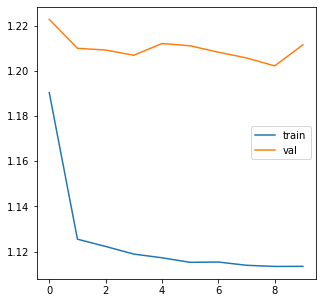

In [336]:
plt.figure(figsize=(5,5))
plt.plot(mean_train_losses)
plt.plot(mean_valid_losses)
plt.legend(["train","val"])
#plt.ylim([1,1.5])

### Histograms of predicted parameter values 

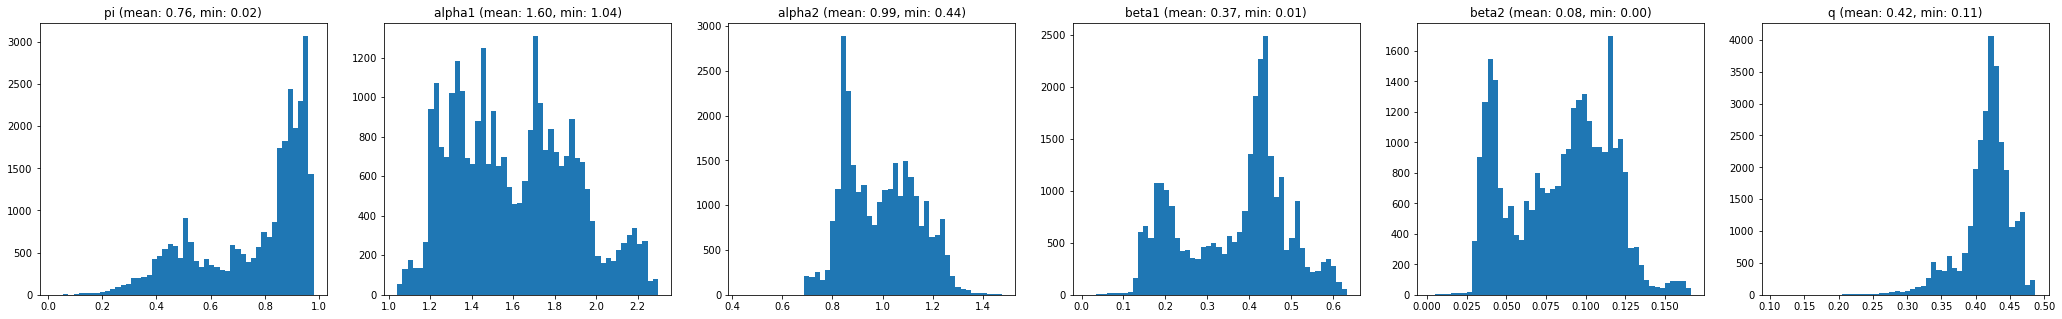

In [337]:
with torch.no_grad():
    inputs = test_dataset.tensors[0]
    outputs = model(inputs)
    
    n = outputs.shape[1]
    
    if model.likelihood=='bgmm':
        variable = ['pi', 'alpha', 'beta']
        
    elif model.likelihood=='b2gmm': 
        variable = ['pi', 'alpha1', 'alpha2', 'beta1', 'beta2', 'q']
        
    elif model.likelihood=='b2sgmm': 
        variable = ['pi', 'alpha1', 'alpha2', 'beta1', 'beta2', 'q', 't']
        
    fig, ax = plt.subplots(1,n, figsize=(6*n, 5), sharex=False, sharey=False)
        
    for i in range(n):
        ax[i].hist(outputs[:,i].numpy(), bins=50)
        ax[i].title.set_text('%s (mean: %.2f, min: %.2f)' % (variable[i], 
                                                             outputs[:,i].mean(), 
                                                             outputs[:,i].min()))

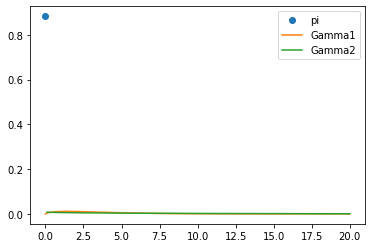

In [344]:
r = np.random.randint(len(outputs))

x = np.linspace (0, 20, 200) 

pi = outputs[r,0]

if model.likelihood=='bgmm':
    alpha = outputs[r,1]
    beta = outputs[r,2]

if model.likelihood!='bgmm':
    alpha1 = outputs[r,1]
    alpha2 = outputs[r,2]
    beta1 = outputs[r,3]
    beta2 = outputs[r,4]
    q = outputs[r,5]

if model.likelihood=='b2sgmm':
    t = outputs[r,6]

plt.plot(0, pi, 'o', label='pi')

if model.likelihood=='bgmm':
    y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
    plt.plot(x, y1*(1-pi).numpy(), label='Gamma')

if model.likelihood!='bgmm':
    y1 = stats.gamma.pdf(x, a=alpha1, scale=1/beta1)
    plt.plot(x, y1*(1-pi).numpy()*q.numpy(), label='Gamma1')
    y2 = stats.gamma.pdf(x, a=alpha2, scale=1/beta2)
    plt.plot(x, y2*(1-pi).numpy()*(1-q).numpy(), label='Gamma2')

if model.likelihood=='b2sgmm':
    plt.plot(t,0,'x', label='t')
    
plt.legend()
plt.show()

In [90]:
import utils
reload(utils)
from utils import *

In [113]:
with torch.no_grad():
    test_outputs = model(test_tensor_x)
    
st_test = build_results_df(st,
                           outputs=test_outputs,
                           st_names_test=st_names_dict['test'],
                           model=model,
                           p=0.05,
                           confidence_intervals=False)

print_summary_of_results(
                        st_test,
                        likelihood_fn=model.likelihood,
                        alldays=True,
                        drydays=True,
                        wetdays=True,
                        wet_threshold=0,
                        )

All Days ¦ Station : Bhuntar ¦ WRF : 109.2 ¦ REG : 87.1 ¦ MLP : 107.9 ¦ Imp(REG) : 20.27% ¦ Imp(MLP) : 1.21% ¦ Imp(MLP_median) : 49.43% ¦ Imp(MLP_median_gamma) : 36.48%
Dry Days ¦ Station : Bhuntar ¦ WRF : 29.5 ¦ REG : 23.1 ¦ MLP : 63.5 ¦ Imp(REG) : 21.83% ¦ Imp(MLP) : -115.24% ¦ Imp(MLP_median) : 90.87% ¦ Imp(MLP_median_gamma) : 7.63%
Wet Days ¦ Station : Bhuntar ¦ WRF : 337.9 ¦ REG : 270.7 ¦ MLP : 235.1 ¦ Imp(REG) : 19.87% ¦ Imp(MLP) : 30.40% ¦ Imp(MLP_median) : 39.04% ¦ Imp(MLP_median_gamma) : 7.63%
-------------------------------------------------------------------------------
All Days ¦ Station : Larji ¦ WRF : 135.8 ¦ REG : 110.3 ¦ MLP : 110.9 ¦ Imp(REG) : 18.81% ¦ Imp(MLP) : 18.33% ¦ Imp(MLP_median) : 41.98% ¦ Imp(MLP_median_gamma) : 38.57%
Dry Days ¦ Station : Larji ¦ WRF : 32.7 ¦ REG : 25.9 ¦ MLP : 54.1 ¦ Imp(REG) : 20.83% ¦ Imp(MLP) : -65.24% ¦ Imp(MLP_median) : 94.29% ¦ Imp(MLP_median_gamma) : 25.72%
Wet Days ¦ Station : Larji ¦ WRF : 459.9 ¦ REG : 375.5 ¦ MLP : 289.6 ¦ Imp(R

### Train model with different hyperparameters

In [135]:
params = OrderedDict(
    lr = [.01]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm', 'b2gmm']
    ,hidden_channels = [10]
    #,k = [0]
    ,k = [0,1,2,3,4]
)

epochs = 5

In [136]:
m = RunManager()
predictions={}
for l in params['likelihood_fn']:
    predictions[l] = {} 

for run in RunBuilder.get_runs(params):
    
    d=6
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    val_tensor_x = torch.Tensor(data[f'X_val_{run.k}'][:,:d]) # transform to torch tensor
    val_tensor_y = torch.Tensor(data[f'Y_val_{run.k}'][:,:d]) # transform to torch tensor
    val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create test dataset
    
    test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data['Y_test'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    val_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, val_loss = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             val_loader, 
                                             epoch=epoch, 
                                             print_progress=False)

        m.epoch_loss = train_loss
        m.epoch_val_loss = val_loss
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        m.end_epoch()
        
        save_as_best = True if val_loss == min(val_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(val_tensor_x)
    
    st_test = build_results_df(st, 
              outputs, 
              #st_names_test=st_names_test,                 
              st_names_test=split_dict[f'k{run.k}']['val'], 
              model=network)
    
    predictions[run.likelihood_fn][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')     

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,k
0,1,1,1.268044e+00,1.147769,1.752646,1.760667,0.01,128,bgmm,10,0
1,1,2,1.168232e+00,1.130330,1.731111,3.519818,0.01,128,bgmm,10,0
2,1,3,1.163251e+00,1.131406,1.720585,5.274433,0.01,128,bgmm,10,0
3,1,4,1.161196e+00,1.139779,1.752623,7.056083,0.01,128,bgmm,10,0
4,1,5,1.159681e+00,1.132515,1.699555,8.784664,0.01,128,bgmm,10,0
5,2,1,1.207009e+00,1.298742,1.760630,1.761631,0.01,128,bgmm,10,1
6,2,2,1.125595e+00,1.282198,1.725083,3.515754,0.01,128,bgmm,10,1
7,2,3,1.123142e+00,1.285762,1.726092,5.277879,0.01,128,bgmm,10,1
8,2,4,1.121657e+00,1.279840,1.741625,7.046528,0.01,128,bgmm,10,1
9,2,5,1.119968e+00,1.274400,1.770635,8.853196,0.01,128,bgmm,10,1


In [137]:
for k in predictions.keys():
    for i in range(len(params['k'])):
        predictions[k][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[k]['k_all'] = predictions[k][f'k{i}']
        else:
            predictions[k]['k_all'] = predictions[k]['k_all'].append(predictions[k][f'k{i}'])

In [138]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')
df.sort_values('valid_loss')

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,k
37,8,3,1.195332e+00,0.995148,2.181620,6.645277,0.01,128,b2gmm,10,2
38,8,4,1.192169e+00,1.003945,2.274162,8.963479,0.01,128,b2gmm,10,2
13,3,4,1.192923e+00,1.005049,1.779636,7.091585,0.01,128,bgmm,10,2
14,3,5,1.192357e+00,1.008130,1.756638,8.884257,0.01,128,bgmm,10,2
39,8,5,1.190835e+00,1.016569,2.233088,11.232600,0.01,128,b2gmm,10,2
36,8,2,1.210935e+00,1.018305,2.207566,4.422620,0.01,128,b2gmm,10,2
11,3,2,1.200785e+00,1.019242,1.738622,3.508259,0.01,128,bgmm,10,2
12,3,3,1.195073e+00,1.021566,1.734627,5.279921,0.01,128,bgmm,10,2
35,8,1,1.341986e+00,1.029438,2.176005,2.178006,0.01,128,b2gmm,10,2
10,3,1,1.433906e+00,1.050276,1.735593,1.737595,0.01,128,bgmm,10,2


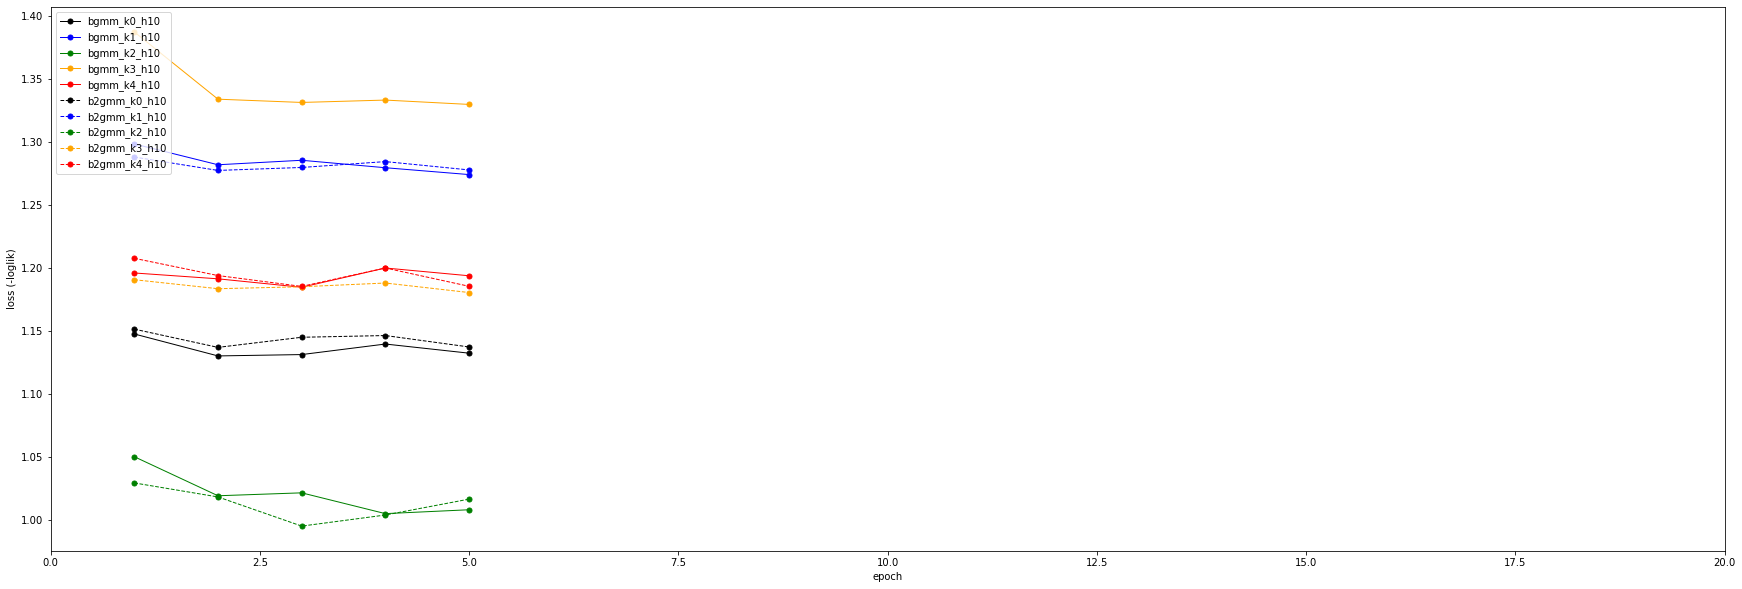

In [139]:
plt.figure(figsize=(30,10))

linecolors = {"0" : "black",
              "1" : "blue",
              "2" : "green",
              "3" : "orange",
              "4" : "red"}

linestyles = {"bgmm" : "solid",
             "b2gmm" : "dashed"}

markerstyles = {"10" : "o",
                "100" : "x"}

style_dict = {"linestyles" : linestyles,
             "linecolors" : linecolors}

for a in df.likelihood_fn.unique():
    for b in df.k.unique():
        for d in df.hidden_channels.unique(): 
            c = df[(df.likelihood_fn == a) & (df.k == b) & (df.hidden_channels == d)].copy()
            plt.plot(c.epoch, 
                     c.valid_loss, 
                     label=f'{a}_k{b}_h{d}', 
                     linestyle=linestyles[a],
                     color = linecolors[str(b)],
                     marker = markerstyles[str(d)],
                     linewidth = 1,
                     markersize = 5
                    )

plt.legend(loc='upper left')
plt.xlim([0,20])
plt.xlabel('epoch')
plt.ylabel('loss (-loglik)')
plt.show()

### Sample from 2-Gamma mixture model and plot

In [141]:
%%time
k = 1
bins = 1000
hist_max = 50
r = np.random.randint(outputs.shape[0], size=k)
print(r)
dist = gmm_fn(pi=outputs[r,0],
            alpha1=outputs[r,1],
            alpha2=outputs[r,2],
            beta1=outputs[r,3],
            beta2=outputs[r,4],
            q=outputs[r,5],
            )

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,hist_max,bins),(torch.histc(dist.sample([1000000]), bins=bins, min=0, max=hist_max)))
plt.plot(dist.mean,np.zeros(k),'or')
plt.plot(test_tensor_y[r],np.zeros(k),'xk',ms=10)
plt.show()

[22288]


IndexError: index 3 is out of bounds for dimension 1 with size 3

### Sample from Bernoulli-Gamma mixture model

In [98]:
interval=5

flag = 0
if flag:

    while True:

        x = np.linspace (0, 100, 200) 
        r = np.random.randint(len(inputs))
        print(r)

        pi = outputs[r,0]
        a = outputs[r,1]
        rate = outputs[r,2]

        y1 = stats.gamma.cdf(x, a=a, scale=1/rate) #a is alpha, loc is beta???

        mu = stats.gamma.mean(a=a, scale=1/rate)
        median = stats.gamma.median(a=a, scale=1/rate)
        mixture_median = stats.gamma.ppf((0.5 - pi) / (1 - pi), a=a, scale=1/rate) if pi < 0.5 else 0
        mixture_mean = (1-pi) * mu

        print("mean: %.2f" % mu)
        print("median: %.2f" % median)
        print("mixture median: %.2f" % mixture_median)
        print("mixture mean: %.2f" % mixture_mean)

        modelled = inputs[r,0]*x_std[0] + x_mean[0]
        observed = tensor_y[r,0]

        if modelled > 0:

            #mu = a/rate if pi<0.5 else 0

            plt.plot(0,pi,"oy", label="pi = %.2f" % pi)

            plt.plot(mu, 0, "or", mfc="white", label="mu = %.2f" % mu)
            plt.plot(median, 0, "xr", label="median = %.2f" % median)  
            plt.plot(mixture_median, 0, "ok", mfc="white", label="mixture median = %.2f" % mixture_median)  
            plt.plot(mixture_mean, 0, "^k", label="mixture median = %.2f" % mixture_mean)  

            plt.plot(modelled, 0, "x", label="WRF = %.2f" % modelled)

            plt.plot(observed, 0, "xg", label="observed = %.2f" % observed)
            plt.plot(x, pi + (1-pi)*y1, "y-", label=(r'$\alpha=%.2f, \beta=%.2f$') % (a, rate))

            plt.ylim([-0.05,1])
            plt.xlim([-0.2, max([1,modelled,observed,mu])*1.20])
            plt.legend(loc="upper right")
            plt.show()

            time.sleep(interval)

        else:
            pass

        clear_output(wait=True)

### Plot time series of predictions

In [193]:
p=0.05
multirun=1

if multirun:
    likelihood_fn = 'b2gmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

In [194]:
import utils, plot_utils
reload(utils)
reload(plot_utils)
from utils import *
from plot_utils import *

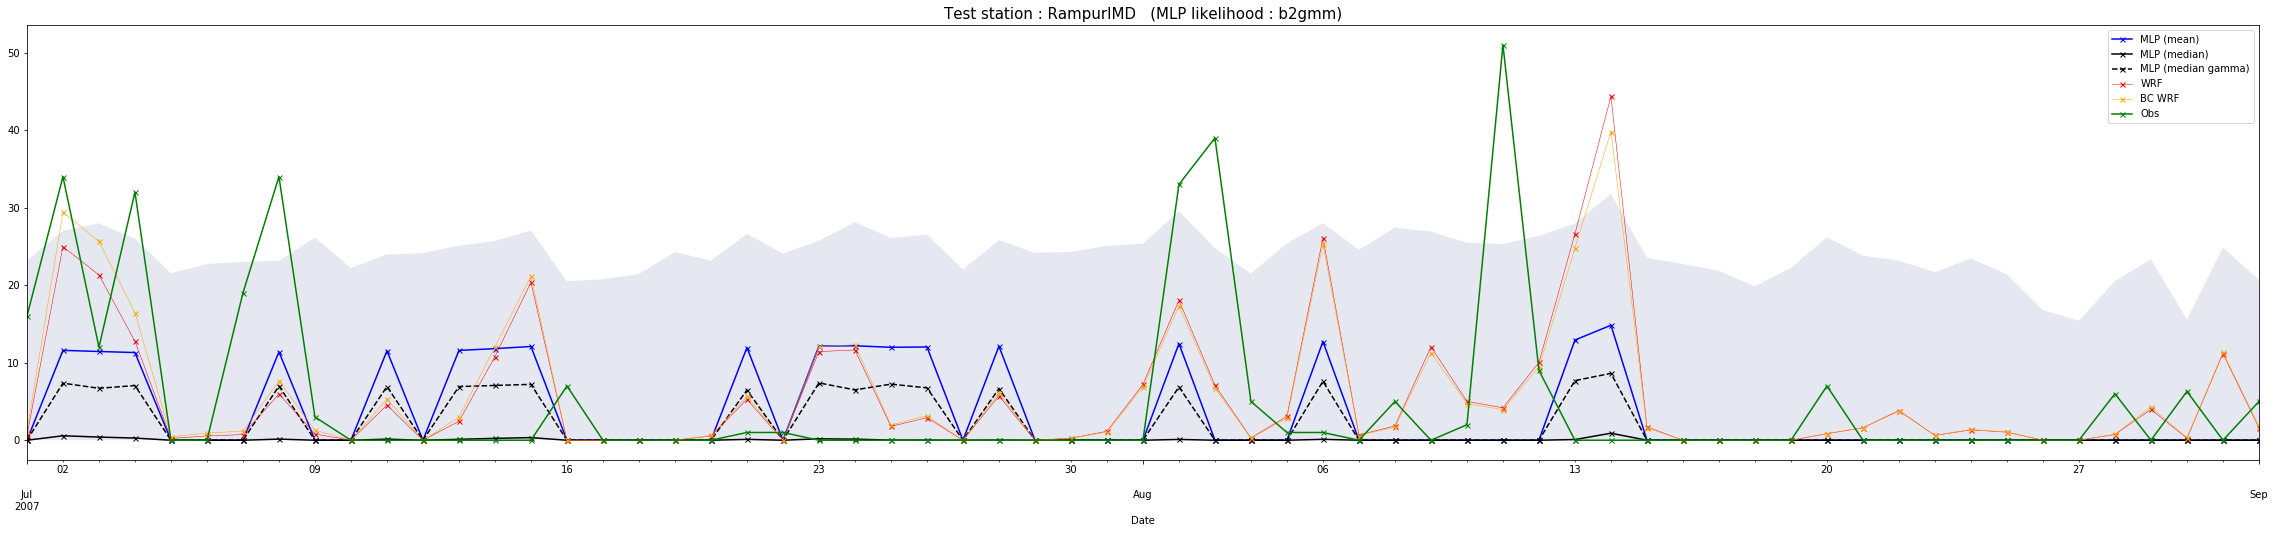

In [196]:
st_names_test = st_test['Station'].unique()

r = np.random.randint(len(st_names_test))
rand_test_st = st_names_test[r]
st_test_r = st_test[st_test['Station']==rand_test_st].copy()

xmin = "2007-07-01"
xmax = "2007-09-01" 

plot_timeseries(st_test_r, 
                likelihood_fn,
                figsize=(40,8),
                xmin = xmin,
                xmax = xmax
               )

#plt.savefig(f"exports/tiemseries_{rand_test_st}_{xmin}_{xmax}.png")

### Print summary of results

In [197]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

All Days ¦ Station : Nadaun ¦ WRF : 175.9 ¦ REG : 241.0 ¦ MLP : 156.1 ¦ Imp(REG) : -37.01% ¦ Imp(MLP) : 11.25% ¦ Imp(MLP_median) : 21.25% ¦ Imp(MLP_median_gamma) : 22.66%
Dry Days ¦ Station : Nadaun ¦ WRF : 41.3 ¦ REG : 99.8 ¦ MLP : 39.2 ¦ Imp(REG) : -141.52% ¦ Imp(MLP) : 5.16% ¦ Imp(MLP_median) : 94.69% ¦ Imp(MLP_median_gamma) : 62.31%
Wet Days ¦ Station : Nadaun ¦ WRF : 7772.7 ¦ REG : 7181.1 ¦ MLP : 6639.9 ¦ Imp(REG) : 7.61% ¦ Imp(MLP) : 14.57% ¦ Imp(MLP_median) : -6.64% ¦ Imp(MLP_median_gamma) : 62.31%
-------------------------------------------------------------------------------
All Days ¦ Station : Palampur ¦ WRF : 435.6 ¦ REG : 421.0 ¦ MLP : 438.5 ¦ Imp(REG) : 3.35% ¦ Imp(MLP) : -0.68% ¦ Imp(MLP_median) : 22.61% ¦ Imp(MLP_median_gamma) : 29.40%
Dry Days ¦ Station : Palampur ¦ WRF : 69.7 ¦ REG : 74.5 ¦ MLP : 42.3 ¦ Imp(REG) : -6.76% ¦ Imp(MLP) : 39.34% ¦ Imp(MLP_median) : 94.01% ¦ Imp(MLP_median_gamma) : 77.54%
Wet Days ¦ Station : Palampur ¦ WRF : 6067.1 ¦ REG : 5870.9 ¦ MLP : 6

In [206]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

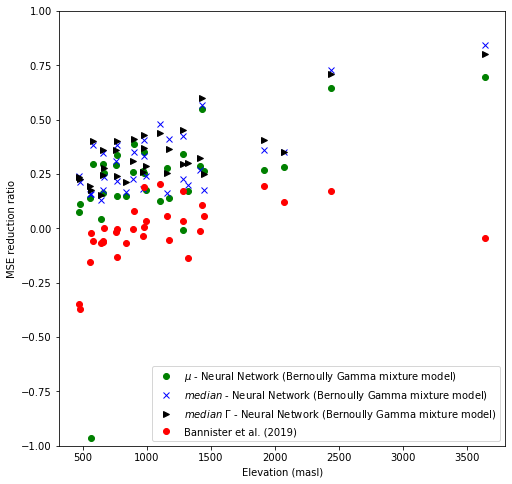

In [207]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark-palette')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_ratio'],'og', label='$\mu$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_ratio'],'xb', label='$median$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_gamma_ratio'],'>k', label='$median$ $\Gamma$ - Neural Network (Bernoully Gamma mixture model)')

plt.plot(st_test_summary['Z'],st_test_summary['se_reg_ratio'],'or', label='Bannister et al. (2019)')

plt.xlabel("Elevation (masl)")
plt.ylabel("MSE reduction ratio")
plt.ylim([-1, 1])
plt.legend()
plt.savefig(f"exports/MSE_plot_{day_filter}.png")
plt.show()

In [208]:
"""plt.figure(figsize=(10,10))

plt.plot(st_test_r['Prec'], st_test_r['se_mlp'],'o',ms=4,label="MLP")
plt.plot(st_test_r['Prec'], st_test_r['se_wrf'],'x',ms=4,label="WRF")

plt.legend()

#plt.ylim([-0,20000])
plt.show()""";

In [209]:
path = '..\..\PhD/gis/exports/beas_watershed.shp'
beas_watershed = geopandas.read_file(path)

path = '..\..\PhD/gis/exports/sutlej_watershed.shp'
sutlej_watershed = geopandas.read_file(path)

In [210]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

gdf = build_geodataframe(st_test_summary, x='X', y='Y')

gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

In [211]:
"""fig, axes = plt.subplots(1, 2, figsize=(15,10), constrained_layout=True)
#color_map = plt.cm.get_cmap('seismic').reversed()
margin = 0.25

for i, ax in enumerate(axes):
    gdf.plot(ax=ax, column='k_fold', legend=True, cmap='Set1', markersize=20, marker="o", linewidth=3)
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    #if i==len(axes)-1:
    #    plt.colorbar(plt.cm.ScalarMappable(cmap='Set1'), ax=ax, shrink=0.6)
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    #ax.set_ylabel(" ")
    #ax.set_xlabel(" ")
    ax.set_axis_off()
    ax.set_aspect(1)

#axes[0].scatter(gdf.X, gdf.Y, c=gdf.se_mlp_ratio, cmap=color_map)
#gdf.plot(ax=axes[0], column='se_mlp_ratio',legend=True, edgecolor = 'white',  cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[0].set_title('MLP', fontsize=16)
#gdf.plot(ax=axes[1], column='se_reg_ratio',legend=True, edgecolor = 'white', cmap=color_map,  markersize=100, vmin=-1, vmax=1)
#axes[1].set_title('Bannister et al. (2019)', fontsize=16)

#plt.legend()
#plt.tight_layout()
plt.show()

#plt.savefig(likelihood_fn+'.png')""";

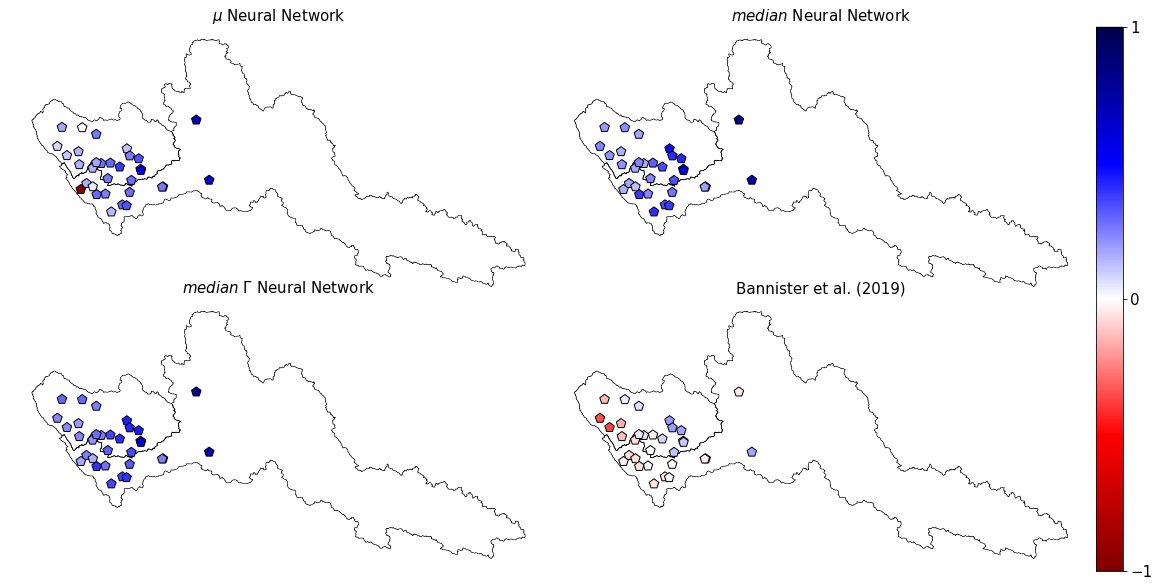

In [212]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
plt.style.use('seaborn-dark-palette')

title = ['$\mu$ Neural Network', '$median$ Neural Network', '$median$ $\Gamma$ Neural Network', 'Bannister et al. (2019)']
var = ['se_mlp_ratio', 'se_mlp_median_ratio', 'se_mlp_median_gamma_ratio', 'se_reg_ratio']

fig = plt.figure(figsize=(20, 20))

color_map = plt.cm.get_cmap('seismic').reversed()

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                #aspect=False,
                axes_pad=0,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.05,
                cbar_size="2.5%"
                )

for i, ax in enumerate(grid):
    ax.set_axis_off()
    ax.set_yticks([])
    ax.set_xticks([])
    
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    
    if i==0:
        gdf_train.plot(ax=ax, markersize=15, color='green')
        gdf_val.plot(ax=ax, markersize=15, color='orange')
    
    sc = ax.scatter(gdf.X, gdf.Y, c=gdf[var[i]], s=100, marker='p', cmap=color_map, vmin=-1, vmax=1, edgecolor='k')
    ax.set_title(title[i], fontsize=15)
    
# when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]
cbar = grid.cbar_axes[0].colorbar(sc)
cbar.ax.set_yticks([-1,0,1])
cbar.ax.tick_params(labelsize=15)
plt.savefig(f'exports/{likelihood_fn}_{np.random.randint(1000)}.png')
plt.show()

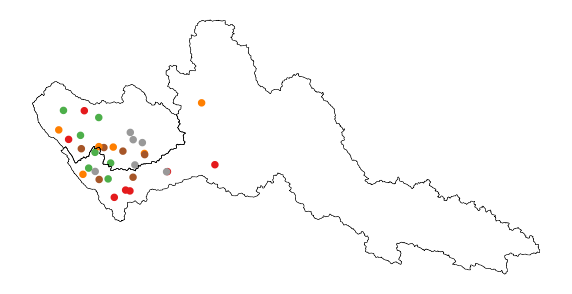

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=20, marker="o", linewidth=3)
beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
ax.set_axis_off()
plt.savefig(f'exports/k_fold_{likelihood_fn}_{np.random.randint(1000)}.png')
plt.show()